# Modello convolutivo di base
Lo scopo di questo notebook è creare un **modello convolutivo di base** con un'architettura semplice. In seguito, sarà interessante confrontare i risultati di questo primo modello con i risultati ottenuti da modelli più complessi, o pre addestrati.

Come al solito, si procede con l'importazione delle librerie utilizzate e la creazione dei set di allenamento e validazione.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
# per il modello con estensione .onnx
import onnxruntime as rt
import tf2onnx
import onnx

In [2]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

label_names = train_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


## Funzioni per processamento dei dati

La prima funzione che ci tornerà utile è `squeeze(audio, labels)`, della quale abbiamo già visto l'implementazione e parlato del suo utilizzo nel notebook dove trattiamo gli spettrogrammi.

In [3]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [4]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
validation_ds = validation_ds.map(squeeze, tf.data.AUTOTUNE)

audio, label = next(iter(train_ds))
print(audio.shape)
print(label.shape)

(32, 16000)
(32,)


Una volta eseguito questa semplificazione, a partire dai tensori degli audio, creeremo gli spettrogrammi che sarannò presi come input dal modello convolutivo.

## Conversione e suddivisione dataset
Per la conversione del dataset utilizziamo due funzioni che abbiamo già definito nel notebook dove trattiamo gli spettrogrammi.

In [5]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    return spectrogram[..., tf.newaxis]

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [6]:
def get_spectrogram_dataset(dataset):
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

Definite le due funzioni possiamo procedere a ottenere il nostro **training set**, **validation set**, e **test set** di spettrogrammi. La suddivisione di dati ricordo essere rispettivamente 60%, 20%, 20%.

In [7]:
train_ds = get_spectrogram_dataset(train_ds)
validation_ds = get_spectrogram_dataset(validation_ds)

val_ds = validation_ds.take(validation_ds.cardinality() // 2) # ho cambiato nome del validation_ds in modo tale da non creare problemi con l'istruzione seguente
test_ds = validation_ds.skip(validation_ds.cardinality() // 2)

In [8]:
print("Numero di audio training set:", len(train_ds) * 32)
print("Numero di audio validation set:", len(val_ds) * 32)
print("Numero di audio test set:", len(test_ds) * 32)

Numero di audio training set: 7776
Numero di audio validation set: 2592
Numero di audio test set: 2592


Shape (forma) spettrogrammi: (32, 124, 129, 1)


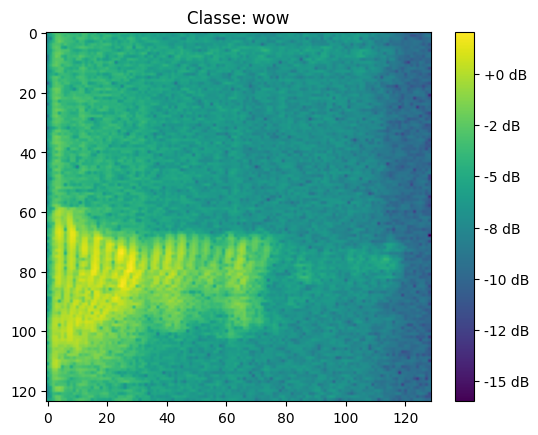

In [9]:
for audio, label in train_ds:
    print("Shape (forma) spettrogrammi:", audio.shape)

    spectrogram = np.squeeze(audio[0], axis=-1)
    spectrogram = np.log(spectrogram.T + np.finfo(float).eps)

    plt.imshow(spectrogram.T)
    plt.colorbar(format='%+2.0f dB') # barra laterale dei dB

    plt.title(f"Classe: {label_names[label[0].numpy()]}")
    break

La grandezza degli spettrogrammi, quindi delle immagini ottenute, è di **124x129**.

## Creazione modello di base

Come modello implementiamo una rete neurale convolutiva. Questo modello ha un'architettura semplice e servirà da benchmark per i modelli futuri.

La rete prende in ingresso tensori di forma **altezza x larghezza x canali**, rispettivamente di **124, 129, 1**. Per farlo lavorare meglio, rendiamo le immagini di dimensione quadrata e normalizziamo i dati con la funzione `tf.keras.layers.Normalization()`.

L'architettura del modello è suddivisa in **due blocchi** principali: un blocco per l'apprendimento delle caratteristiche e un blocco per la classificazione.

Il **blocco di apprendimento delle caratteristiche** ha un'architettura formata da una serie di livelli convolutivi alternati a livelli di max pooling. Per ciascun livello convolutivo viene anche applicata la funzione di attivazione **ReLu** per applicare non linearità. Il blocco termina con un livello convolutivo di **256 filtri**, che corrispondono alla stessa quantità di filtri applicati dal livello convolutivo precedente.

Terminato il blocco di apprendimento delle caratteristiche, è presente il **blocco di classificazione**, formato da un **livello di Flatten**, necessario per trasformare i dati in un vettore unidimensionali, e un **livello Dense**, necessario per la predizione della classe di appartenenza del dato. Quest'ultimo livello Dense ha **30 unità**, che corrispondono alle 30 classi del nostro task di classificazione multiclasse. La funzione di attivazione applicata dal livello Dense è la **softmax**, ideale per i task di classificazione multiclasse.

La funzione **softmax**, a differenza della funzione **sigmoid** ci fornisce una distribuzione di probabilità sulle classi possibili (questa distribuzione saremo in grado di visualizzarla durante la valutazione del modello).

In [10]:
def get_basic_model():
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=(124, 129, 1), name="inputs")
    x = tf.keras.layers.Normalization(name="normalizzazione")(inputs)

    # Blocco di apprendimento delle caratteristiche
    conv2D_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same", name="conv2D_1")(x)
    MaxPooling2D_1 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_1")(conv2D_1)
    conv2D_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same", name="conv2D_2")(MaxPooling2D_1)
    MaxPooling2D_2 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_2")(conv2D_2)
    conv2D_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same", name="conv2D_3")(MaxPooling2D_2)
    MaxPooling2D_3 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_3")(conv2D_3)
    conv2D_4 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same", name="conv2D_4")(MaxPooling2D_3)
    MaxPooling2D_4 = tf.keras.layers.MaxPooling2D(pool_size=2, name="MaxPooling2D_4")(conv2D_4)
    conv2D_5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same", name="conv2D_5")(MaxPooling2D_4)

    # Blocco di classificazione
    Flatten = tf.keras.layers.Flatten(name="Flatten")(conv2D_5)
    outputs = tf.keras.layers.Dense(30, activation="softmax", name="dense_output")(Flatten)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

Nella prossima cella di codice dichiariamo l'**ottimizzatore** da utilizzare (rmsprop), le **metriche** di cui tenere traccia (accuratezza), e la funzione di perdita da utilizzare per il calcolo del gradiente. Nel nostro caso la **funzione di perdita** corrisponde alla `sparse_categorical_crossentropy`, una variante della `categorical_crossentropy`.

La **sparse categorical crossentropy** viene utilizzata quando le classi sono rappresentate come interi, proprio come nel nostro caso.

In [11]:
basic_model = get_basic_model()
basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

basic_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 124, 129, 1)]     0         
                                                                 
 normalizzazione (Normalizat  (None, 124, 129, 1)      3         
 ion)                                                            
                                                                 
 conv2D_1 (Conv2D)           (None, 124, 129, 32)      320       
                                                                 
 MaxPooling2D_1 (MaxPooling2  (None, 62, 64, 32)       0         
 D)                                                              
                                                                 
 conv2D_2 (Conv2D)           (None, 62, 64, 64)        18496     
                                                                 
 MaxPooling2D_2 (MaxPooling2  (None, 31, 32, 64)       0     

Il modello ha un totale di circa **1.4 milioni di parametri**, bilanciando complessità e capacità di apprendimento.

In [12]:
basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/rmsprop/basic_model.keras", save_best_only=True, monitor="val_loss")]
basic_model_history = basic_model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=basic_model_callbacks)

Epoch 1/30
243/243 [==============================] - 6s 12ms/step - loss: 2.4098 - accuracy: 0.3387 - val_loss: 1.3949 - val_accuracy: 0.6096
Epoch 2/30
243/243 [==============================] - 3s 11ms/step - loss: 1.0341 - accuracy: 0.7148 - val_loss: 0.7817 - val_accuracy: 0.7778
Epoch 3/30
243/243 [==============================] - 3s 11ms/step - loss: 0.5507 - accuracy: 0.8429 - val_loss: 0.7241 - val_accuracy: 0.8005
Epoch 4/30
243/243 [==============================] - 3s 11ms/step - loss: 0.3507 - accuracy: 0.8973 - val_loss: 0.7854 - val_accuracy: 0.8511
Epoch 5/30
243/243 [==============================] - 3s 11ms/step - loss: 0.2445 - accuracy: 0.9299 - val_loss: 0.8398 - val_accuracy: 0.8387
Epoch 6/30
243/243 [==============================] - 3s 11ms/step - loss: 0.1768 - accuracy: 0.9457 - val_loss: 0.6295 - val_accuracy: 0.8723
Epoch 7/30
243/243 [==============================] - 3s 11ms/step - loss: 0.1527 - accuracy: 0.9580 - val_loss: 0.8168 - val_accuracy: 0.8692

Alleniamo il modello per 30 epoche e visualizziamo le **curve di addestramento** e **validazione**.

In modo tale da poter accedere ai dati del modello più facilmente in futuro trasformiamo la history del modello in un dataframe pandas. Questo facilità anche al visualizzazione dei dati salvati per un caso futuro.

In [13]:
def convert_history_to_csv(model_history):
    # converto la history del dataframe in un dataframe pandas
    model_history_df = pd.DataFrame(model_history.history)
    # cambio il nome dell'indice e lo imposto a partire da 1
    model_history_df.index = range(1, len(model_history_df) + 1)
    model_history_df.index.name = "epochs"

    return model_history_df

Salvo i dati della history del modello in un file csv.

In [14]:
basic_model_history_df = convert_history_to_csv(basic_model_history)
basic_model_history_df.to_csv("model_histories/rmsprop/basic_model_history.csv")

Inoltre abbiamo salvato il miglior modello nellas seguente directory `bestmodels/rmsprop/` con il nome `basic_model.keras`. L'estensione keras potrebbe crearci problemi di corruzioni se utilizziamo versioni differenti di pacchetti o python, perciò lo convertiamo nello standard onnx.

Per convertirlo nello standard onnx procediamo a utilizzare le librerie **tf2onnx** e **onnx**, importate precedentemente.

In [15]:
def convert_model_to_onnx(model_path, input_shape):
    model = tf.keras.models.load_model(model_path)

    onnx_path = model_path.split(".")[:-1] + ["onnx"]
    onnx_path = ".".join(onnx_path)
    
    input_signature = [tf.TensorSpec((None, *input_shape), tf.float32, name="input")]
    onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature)

    onnx.save(onnx_model, onnx_path)

In [16]:
convert_model_to_onnx("bestmodels/rmsprop/basic_model.keras", (124, 129, 1))

In [17]:
def create_train_val_plot(history, overfit=True):
    # definisco numero epoche
    epochs = range(1, len(history['accuracy']) + 1)

    # Accuracy
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    fig_acc, ax_acc = plt.subplots()

    # linea di base
    ax_acc.plot(epochs, [0.5 for x in range(len(epochs))], color="lightgray", linestyle="--", label="Base")
    # linee di accuratezza
    ax_acc.plot(epochs, accuracy, color="slategray", label="Accuratezza in addestramento")
    ax_acc.plot(epochs, val_accuracy, color="indianred", label="Accuratezza in validazione")
    # miglior accuratezza validazione
    ax_acc.axhline(y=max(val_accuracy), c='indianred', alpha=0.7, linestyle='--')
    ax_acc.text(len(epochs) * 1.07, max(val_accuracy), round(max(val_accuracy), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_acc.spines["right"].set_visible(False)
    ax_acc.spines["top"].set_visible(False)
    ax_acc.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_acc.set_title("Accuratezza in addestramento e validazione")
    ax_acc.set_xlabel("Epoche")
    ax_acc.set_ylabel("Accuratezza (%)")
    ax_acc.legend()

    # Loss
    loss = history['loss']
    val_loss = history['val_loss']

    fig_loss, ax_loss = plt.subplots()

    # linee di loss
    ax_loss.plot(epochs, loss, color="slategray", label="Perdita in addestramento")
    ax_loss.plot(epochs, val_loss, color="indianred", label="Perdita in validazione")
    # miglior loss validazione
    ax_loss.axhline(y=min(val_loss), c='indianred', alpha=0.7, linestyle='--')
    ax_loss.text(len(epochs) * 1.07, min(val_loss), round(min(val_loss), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_loss.spines["right"].set_visible(False)
    ax_loss.spines["top"].set_visible(False)
    ax_loss.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_loss.set_title("Perdita in addestramento e validazione")
    ax_loss.set_xlabel("Epoche")
    ax_loss.set_ylabel("Perdita")

    handles, _ = ax_loss.get_legend_handles_labels()

    if overfit:
        # area overfit
        rect = mpatches.Rectangle((np.argmin(val_loss) + 1, 0), width=100 - np.argmin(val_loss), height=max(max(loss), max(val_loss)), color='lightcoral', alpha=0.3)
        ax_loss.add_patch(rect)
        # patch overfit per legenda
        overfit = mpatches.Patch(color='indianred', alpha=0.3, label='Area overfit')
        handles, _ = ax_loss.get_legend_handles_labels()
        handles.append(overfit)

    # legenda
    ax_loss.legend(handles=handles)

    plt.show()

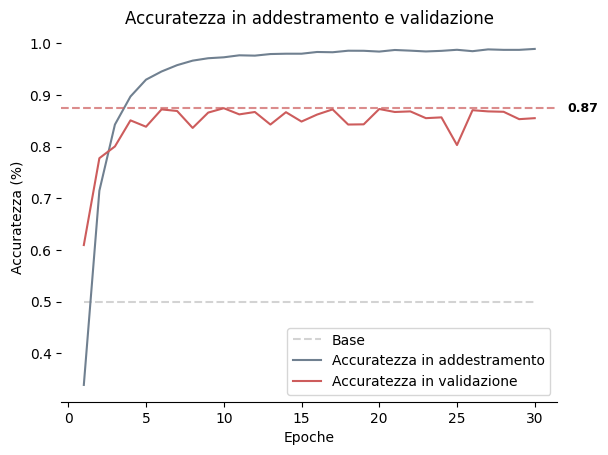

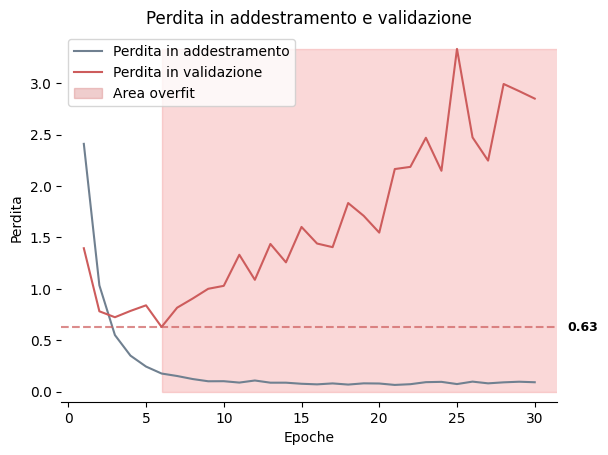

In [18]:
create_train_val_plot(basic_model_history.history)

Questi grafici mostrano come il nostro modello sia andato immediatamente in overfitting. L'accuratezza dell'addestramento aumenta col tempo e raggiunge quasi il **100%**, mentre l'accuratezza della validazione si attesta sull'**85%** con un **picco del 87%**. Inoltre, la **perdita nel set di addestramento** continua a diminuire dopo la **quinta epoca** mentre la **perdita nel set di validazione** aumenta.

Possiamo verificare l'accuratezza della migliore versione del nostro modello di base ricaricando il file **basic_model.keras**

In [19]:
best_basic_model = tf.keras.models.load_model("bestmodels/rmsprop/basic_model.keras")
test_loss, test_acc = best_basic_model.evaluate(test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 8ms/step - loss: 0.7288 - accuracy: 0.8574
Accuratezza: 0.857


Oppure possiamo verificarla con il file **basic_model.onnx**

In [42]:
def evaluate_onnx_model(path_model_onnx, test_ds):
    # il fatto che sia suddiviso in batch mi crea problemi, perciò lo risolvo togliendoli
    test_ds = test_ds.unbatch()
    
    # carico il modello utilizzando il file onnx
    m = rt.InferenceSession(path_model_onnx)
    
    # trasformo il dataset in array numpy
    spectrogram_np = np.array([spectrogram.numpy() for spectrogram, _ in test_ds])
    labels_np = np.array([label.numpy() for _, label in test_ds])
    
    # eseguo le predizione del modello
    pred_onnx = m.run(None, {'input': spectrogram_np})
    # ottengo la predizione corretta
    predictions = np.argmax(pred_onnx[0], axis=1)
    # computo la accuratezza
    accuracy = np.mean(predictions == labels_np)
    # stampo l'accuratezza
    print(f"Accuratezza: {accuracy:.3f}")

In [21]:
evaluate_onnx_model("bestmodels/rmsprop/basic_model.onnx", test_ds)

Accuratezza: 0.857


Abbiamo ottenuto un'**accuratezza** del **85.7%**! Lo riteniamo un buon risultato considerato il task non banale.

Infine, creiamo una funzione utile a visualizzare graficamente la distribuzione di accuratezza delle classi su un'immagine casuale, per capire come ha lavorato il modello. Nel caso il modello non predica correttamente, la **classe corretta** verrà sempre evidenziata di **verde** mentre la **classe predetta** verrà evidenziata di **giallo**.

In [22]:
def create_distribution_plot(model, audio, label):
    prediction = model(audio) # otteniamo la predizione del modello sull'audio preso in input

    random_audio_index = np.random.randint(0, len(prediction) - 1) # abbiamo notato che mostravamo sempre la classe no, magari così cambia un po' le classi che mostriamo

    softmax_pred = tf.nn.softmax(prediction[random_audio_index]) # dobbiamo applicare nuovamente la softmax in modo tale da avere dei dati leggibili
    pred_label = np.argmax(softmax_pred) # ci salviamo l'indice della label predetta dal nostro modello, quella con la probabilità più alta

    colors = ['indianred'] * len(label_names) # creiamo un vettore di lunghezza 30 (la quantità delle nostre label) colorate di rosso

    if pred_label == label[random_audio_index].numpy(): # se la label che abbiamo predetto è corretta, allora la coloriamo di verde
        colors[pred_label] = 'seagreen'
    else: # se la label che abbiamo predetto è sbagliata, allora coloriamo di verde la corretta e di gialla la predetta
        colors[pred_label] = 'khaki'
        colors[label[random_audio_index].numpy()] = 'seagreen'

    plt.figure(figsize=(12, 4))

    plt.bar(label_names, softmax_pred.numpy(), color=colors)
    plt.xticks(rotation=45)

    # dichiariamo i colori della legenda
    other_values_patch = mpatches.Patch(color='indianred', label='Altre classi')
    pred_value_patch = mpatches.Patch(color='khaki', label='Classe predetta')
    correct_value_patch = mpatches.Patch(color='green', label='Classe corretta')

    # disegniamo al legenda con i colori necessari
    if pred_label == label[random_audio_index].numpy(): # se abbiamo predetto correttamente la label, non è necessario mostrare il colore giallo (non è presente nel plot)
        plt.legend(handles=[other_values_patch, correct_value_patch])
    else:
        plt.legend(handles=[other_values_patch, pred_value_patch, correct_value_patch])

    plt.show()

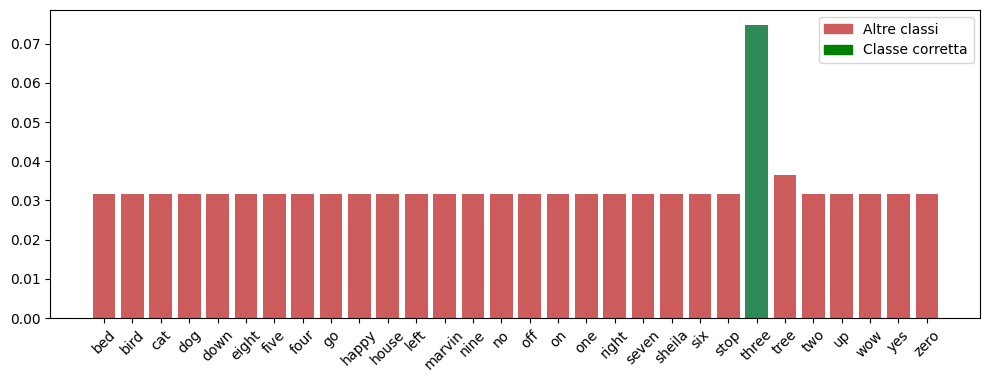

In [32]:
for audio, label in test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_basic_model, audio, label)
    break

Possiamo notare dalla distribuzione che il modello in questo caso ha predetto correttamente la **classe three**. Da un modello così basilare possiamo aspettarci qualceh dubbio su classi simili, ergo gli spettrogrammi, tra loro, come per "three" e "tree". Possiamo infatti notare che la **classe tree** pur non essendo stata predetta e non essendo quella corretta, ha qualche punto percentuale in più delle altre classi errate.

### Risoluzione dell'overfitting
Abbiamo capito che il modello è andato immediatamente in **overfitting**, e lo possiamo notare dalla loss di validazione che inizia a salire dalla quinta epoca in poi. L'obbiettivo principale in questo momento è evitare che vada in overfitting troppo velocemente, applicando le tecniche viste a lezione.

Attualmente per ridurre l'overfitting stiamo applicando **un livello di Dropout**. Il livello di dropout imposta **randomicamente** delle attivazioni a 0, perciò stiamo disattivando qualche neurone. Nello specifico stiamo **azzerando** un certo numero di caratteristiche di uscita dello strato Dense. L'idea dietro questa tecnica è quella di far sforzare maggiormente il modello.

In [33]:
def get_improved_basic_model():
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = tf.keras.layers.Normalization()(inputs)

    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [34]:
improved_basic_model = get_improved_basic_model()
improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [35]:
improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/rmsprop/improved_basic_model.keras", save_best_only=True, monitor="val_loss")]
improved_history = improved_basic_model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=improved_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 4s 11ms/step - loss: 2.8897 - accuracy: 0.1861 - val_loss: 2.3027 - val_accuracy: 0.3565
Epoch 2/100
243/243 [==============================] - 3s 11ms/step - loss: 1.7738 - accuracy: 0.4938 - val_loss: 1.3707 - val_accuracy: 0.5868
Epoch 3/100
243/243 [==============================] - 3s 11ms/step - loss: 1.1414 - accuracy: 0.6675 - val_loss: 1.0017 - val_accuracy: 0.7218
Epoch 4/100
243/243 [==============================] - 3s 10ms/step - loss: 0.8196 - accuracy: 0.7637 - val_loss: 1.0103 - val_accuracy: 0.7284
Epoch 5/100
243/243 [==============================] - 3s 11ms/step - loss: 0.6434 - accuracy: 0.8142 - val_loss: 0.8397 - val_accuracy: 0.7554
Epoch 6/100
243/243 [==============================] - 3s 11ms/step - loss: 0.5152 - accuracy: 0.8455 - val_loss: 0.6227 - val_accuracy: 0.8275
Epoch 7/100
243/243 [==============================] - 3s 11ms/step - loss: 0.4092 - accuracy: 0.8799 - val_loss: 0.8807 - val_accuracy:

Salviamo come prima la history del modello in un file csv.

In [36]:
improved_history_df = convert_history_to_csv(improved_history)
improved_history_df.to_csv("model_histories/rmsprop/improved_history.csv")

Inoltre salviamo nuovamente il miglior modello anche nel formato **.onnx**.

In [37]:
convert_model_to_onnx("bestmodels/rmsprop/improved_basic_model.keras", (124, 129, 1))

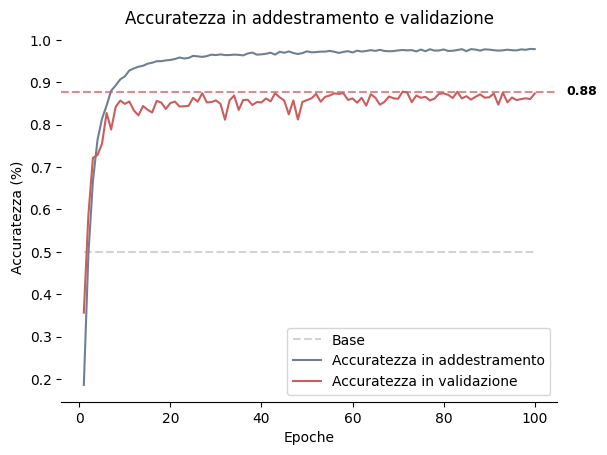

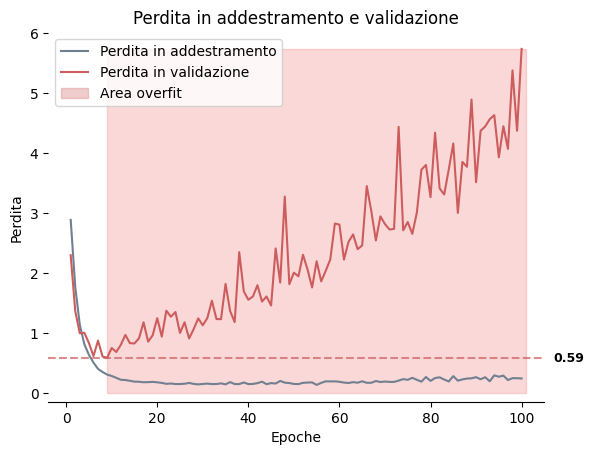

In [38]:
create_train_val_plot(improved_history.history)

Alleniamo il modello per 100 epoche e visualizziamo le **curve di addestramento** e **validazione**.

L'obbiettivo di ridurre **l'overfitting è stato comunque raggiunto**, dato che il modello ha iniziato ad andare in overfitting leggermente dopo, quindi verso **l'epoca 10**, ma dobbiamo sicuramente applicare qualche altra tecnica per migliorarlo ulteriormente.

In [39]:
improved_best_model = tf.keras.models.load_model("bestmodels/rmsprop/improved_basic_model.keras")
test_loss, test_acc = improved_best_model.evaluate(test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 7ms/step - loss: 0.7073 - accuracy: 0.8450
Accuratezza: 0.845


Verifichiamola anche con il modello **.onnx**

In [43]:
evaluate_onnx_model("bestmodels/rmsprop/improved_basic_model.onnx", test_ds)

Accuratezza: 0.845


Abbiamo ottenuto un leggero peggioramento dell'accuratezza, attualmente siamo a quota **84.5%**!.

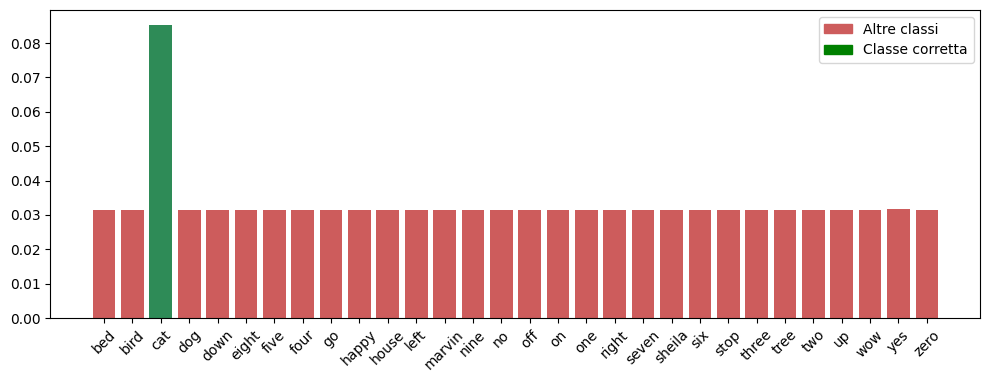

In [44]:
for audio, label in test_ds:
    create_distribution_plot(improved_best_model, audio, label)
    break

In questo caso il modello è stato in grado di predirre la classe corretta **cat**.

## Miglioramenti all'architettura del modello

Durante il corso abbiamo visto anche delle best practice architetturali che possono aiutare a ottenere maggiori prestazioni col modello. Il nostro scopo è provare le tecniche viste e studiate durante il corso e capire come reagiscono al task.

Le tre tecniche che andremo ad applicare sono:
- blocchi residuali
- normalizzazione dei batch
- convoluzioni separabili

### Blocchi residuali
I blocchi residuali sono un'applicazione efficace quando riscontriamo il problema dei **gradienti che svaniscono**. Non sono una tecnica strettamente legata ai modelli convolutivi, ma sono una best practice generale che viene applicare nella maggior parte delle architetture.

I **gradienti che vaniscono** sono causati dalle **catene di funzioni troppo lunghe**, che nel nostro caso non sono altro che **una sequenza di livelli convolutivi**. Per ogni livello convolutivo **una certa quantità di rumore** viene introdotta, finché essa non arriva a **sopraffare** le informazioni sul gradiente.

Se le informazioni sul gradiente sono sopraffatte la **backpropagation smette di funzionare**, e quindi il nostro **modello non impara**.

L'**idea basilare** dietro ai blocchi residuali è quella di **salvare l'informazione** contenuta nell'input precedente al livello convolutivo, e **sommarla all'output** dello stesso livello convolutivo.

Per applicare i blocchi residuali abbiamo implementato la funzione `residual_block(x, filters, pooling=False)` vista a lezione. La funzione è ovviamente adattata al modello da noi implementato, e utilizza le altre due best practice citate precedentemente.

In [45]:
def residual_block(x, filters, pooling=False):
    residual = x

    x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    if pooling:
      x = tf.keras.layers.MaxPooling2D(pool_size=2, padding="same")(x)
      residual = tf.keras.layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
      residual = tf.keras.layers.Conv2D(filters, 1)(residual)

    x = tf.keras.layers.add([x, residual])
    return x

### Normalizzazione dei batch e convoluzioni separabili
La **normalizzazione dei batch** è un concetto che abbiamo già affrontato nel notebook, infatti il suo scopo rimane quello di rendere i dati **più simili tra loro** centrandoli sullo zero, e ciò aiuta la **propagazione del gradiente**. Questa normalizzazione, a differenza della precedente, è in grado di normalizzare i dati in modo adattivo anche quando la media e la varianza cambiano durante l'addestramento.

Le **convoluzione separabili** invece sono un **sostituto** ai livelli convolutivi utilizzati fino ad adesso, e offrono un modello con maggiori prestazioni e meno parametri.

In [46]:
def bp_basic_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(124, 129, 1))
    # x = data_augmentation(inputs)
    x = tf.keras.layers.Resizing(120, 120)(inputs)

    x = residual_block(x, 32, pooling=True)
    x = residual_block(x, 64, pooling=True)
    x = residual_block(x, 128, pooling=True)
    x = residual_block(x, 256, pooling=True)
    x = residual_block(x, 256, pooling=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [47]:
bp_basic_model = bp_basic_model()
bp_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

bp_basic_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 124, 129, 1  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 120, 120, 1)  0           ['input_2[0][0]']                
                                                                                                  
 separable_conv2d (SeparableCon  (None, 120, 120, 32  41         ['resizing[0][0]']               
 v2D)                           )                                                                 
                                                                                            

Le best practice, insieme al `tf.keras.layers.GlobalAveragePooling2D()` applicato al posto del Flatten, hanno formato un modello con circa **160000 parametri addestrabili** (circa il 16% del modello precedente).

In [48]:
bp_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/rmsprop/bp_basic_model.keras", save_best_only=True, monitor="val_loss")]
bp_model_history = bp_basic_model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=bp_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 6s 20ms/step - loss: 3.1730 - accuracy: 0.1290 - val_loss: 3.3651 - val_accuracy: 0.0428
Epoch 2/100
243/243 [==============================] - 5s 20ms/step - loss: 2.5466 - accuracy: 0.2874 - val_loss: 2.6898 - val_accuracy: 0.1971
Epoch 3/100
243/243 [==============================] - 5s 20ms/step - loss: 2.0136 - accuracy: 0.4639 - val_loss: 1.7817 - val_accuracy: 0.5343
Epoch 4/100
243/243 [==============================] - 5s 20ms/step - loss: 1.5233 - accuracy: 0.6034 - val_loss: 1.3567 - val_accuracy: 0.6323
Epoch 5/100
243/243 [==============================] - 5s 20ms/step - loss: 1.1999 - accuracy: 0.6814 - val_loss: 1.2883 - val_accuracy: 0.6381
Epoch 6/100
243/243 [==============================] - 5s 20ms/step - loss: 1.0061 - accuracy: 0.7349 - val_loss: 1.2315 - val_accuracy: 0.6381
Epoch 7/100
243/243 [==============================] - 5s 19ms/step - loss: 0.8406 - accuracy: 0.7765 - val_loss: 0.8960 - val_accuracy:

Salviamo nuoavmente la history del modello in un file csv.

In [49]:
bp_model_history_df = convert_history_to_csv(bp_model_history)
bp_model_history_df.to_csv("model_histories/rmsprop/bp_model_history.csv")

Convertiamo anche il miglior modello nel formato **.onnx**.

In [50]:
convert_model_to_onnx("bestmodels/rmsprop/bp_basic_model.keras", (124, 129, 1))

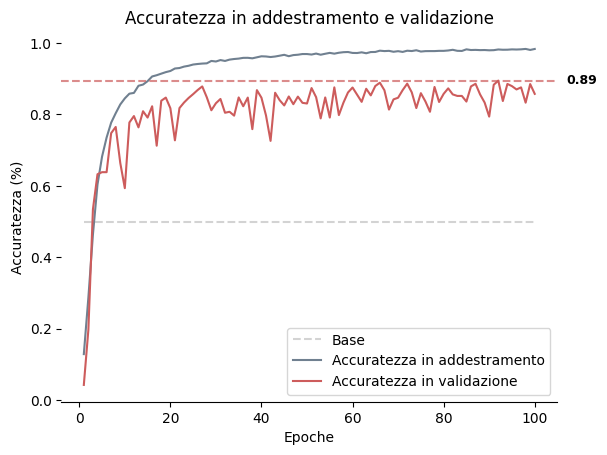

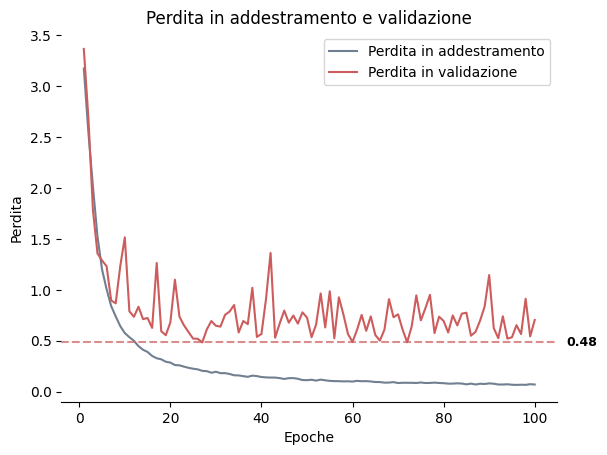

In [51]:
create_train_val_plot(bp_model_history.history, overfit=False)

Possiamo notare che il modello **NON ha raggiunto una vera fase di overfitting**, ma la validazione non ha mostrato un incremento sostanziale all'aumentare delle epoche (probabilmente dovuto dalle tecniche di overfitting non totalmente implementate). La **loss della validazione** stava continuando a scendere, e allo stesso tempo **l'accuratezza della validazione era crescente**.

In [52]:
best_bp_basic_model = tf.keras.models.load_model("bestmodels/rmsprop/bp_basic_model.keras")
test_loss, test_acc = best_bp_basic_model.evaluate(test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 6ms/step - loss: 0.4582 - accuracy: 0.8799
Accuratezza: 0.880


Verifichiamola anche con il modello **.onnx**.

In [ ]:
evaluate_onnx_model("bestmodels/rmsprop/bp_basic_model.onnx", test_ds)

Abbiamo nuovamente ottenuto dei miglioramenti sostanziali per quanto riguarda l'accuratezza, ottenendo un **88%**. Questo risultato è ottimo, considerando che il modello ha il **16% dei parametri** del precedente.

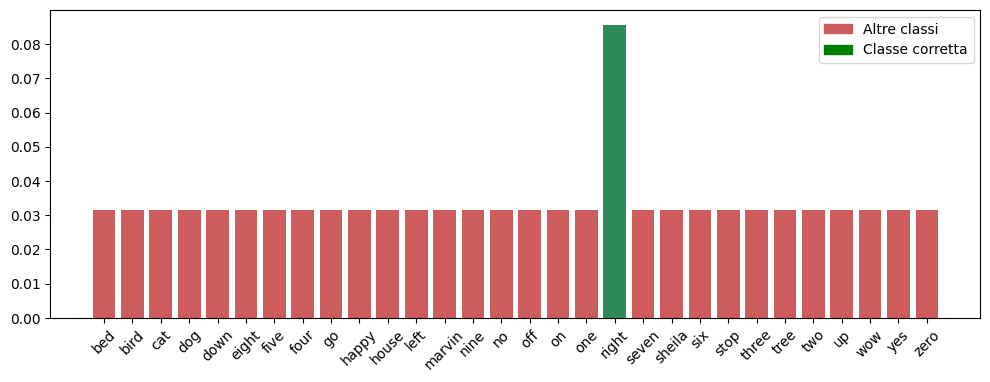

In [31]:
for audio, label in test_ds:
    create_distribution_plot(best_bp_basic_model, audio, label)
    break

La decisione del modello in questo caso è nuovamente molto chiara.